# TransMorph-affine model

# Training

In [1]:
# Import packages

In [14]:
import os, utils, glob, losses
import sys
from torch.utils.data import DataLoader
from data import datasets, trans
import numpy as np
import torch, TransMorph_affine
from torchvision import transforms
from torch import optim
import matplotlib.pyplot as plt
from TransMorph_affine import CONFIGS as CONFIGS
from natsort import natsorted

In [15]:
# create average meter for recording loss values

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
# Learning rate adjustment function

In [6]:
def adjust_learning_rate(optimizer, epoch, MAX_EPOCHES, INIT_LR, power=0.9):
    for param_group in optimizer.param_groups:
        param_group['lr'] = round(INIT_LR * np.power( 1 - (epoch) / MAX_EPOCHES ,power),8)

In [7]:
# Setup GPUs

In [21]:
'''
GPU configuration
'''
GPU_iden = 6
GPU_num = torch.cuda.device_count()
print('Number of GPU: ' + str(GPU_num))
for GPU_idx in range(GPU_num):
    GPU_name = torch.cuda.get_device_name(GPU_idx)
    print('     GPU #' + str(GPU_idx) + ': ' + GPU_name)
torch.cuda.set_device(GPU_iden)
GPU_avai = torch.cuda.is_available()
print('Currently using: ' + torch.cuda.get_device_name(GPU_iden))
print('If the GPU is available? ' + str(GPU_avai))

Number of GPU: 8
     GPU #0: NVIDIA RTX A5000
     GPU #1: NVIDIA RTX A5000
     GPU #2: NVIDIA RTX A5000
     GPU #3: NVIDIA RTX A5000
     GPU #4: NVIDIA RTX A5000
     GPU #5: NVIDIA RTX A5000
     GPU #6: NVIDIA RTX A5000
     GPU #7: NVIDIA RTX A5000
Currently using: NVIDIA RTX A5000
If the GPU is available? True


In [9]:
# Setup directory names and training hyperparameters

In [17]:
batch_size = 1
train_dir = '/data_local/mbhosale/CHAOS/CHAOS_Train_Sets/Train_Sets/MR/'
test_dir = '/data_local/mbhosale/CHAOS/CHAOS_Train_Sets/Train_Sets/MR/'
save_dir = '/data_local/mbhosale/CHAOS/CHAOS_Train_Sets/Train_Sets/TransMorph_affine_NCC/'
if not os.path.exists('experiments/'+save_dir):
    os.makedirs('experiments/'+save_dir)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
lr = 0.0001
epoch_start = 0
max_epoch = 35
cont_training = False

In [20]:
# Create TransMorph-affine model

In [22]:
config = CONFIGS['TransMorph-Affine']
AffInfer = TransMorph_affine.ApplyAffine()
AffInfer.cuda()
model = TransMorph_affine.SwinAffine(config)
model.cuda()
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

In [23]:
# If continue training

In [30]:
if cont_training:
    epoch_start = 335
    model_dir = 'experiments/'+save_dir
    updated_lr = round(lr * np.power(1 - (epoch_start) / max_epoch,0.9),8)
    best_model = torch.load(model_dir + natsorted(os.listdir(model_dir))[0])['state_dict']
    model.load_state_dict(best_model)
else:
    updated_lr = lr
print('Current learning rate: {}'.format(updated_lr))

Current learning rate: 0.0001


In [24]:
# Setup PyTorch Dataset

In [19]:
# train_composed = transforms.Compose([trans.Pad3DIfNeeded((180, 180, 180)),
                                    #  trans.CenterCropBySize((160, 160, 160)),
                                    #  trans.NumpyType((np.float32, np.float32)),
                                    #  ])

# test_composed = transforms.Compose([trans.Pad3DIfNeeded((180, 180, 180)),
                                #    trans.CenterCropBySize((160, 160, 160)),
                                #    trans.NumpyType((np.float32, np.float32)),
                                #    ])

# train_set = datasets.CTDataset(glob.glob(train_dir + '*.pkl'))
# test_set = datasets.CTDataset(glob.glob(test_dir + '*.pkl'))
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
# test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
import math
import sys
sys.path.insert(0,'../dataset/')
import chaos
CHAOS_PATH = r'/home/csgrad/mbhosale/Datasets/CHAOS/'
downsample_rate = 16
pad_size = [256, 256, 50] # for T1DUAL [256, 256, 50] # TODO Why is it 320 for T2spir ? 
tr_path = CHAOS_PATH + r"CHAOS_Train_Sets/Train_Sets/MR"
tst_path = CHAOS_PATH + r"CHAOS_Train_Sets/Train_Sets/MR" # we are choosing train dataset as test because we dont have ground truth in the test
# TODO But we can change the test modality, but for now we have kept it same 
train_dataloader, test_dataloader = chaos.Chaos_dataloader(root_path=CHAOS_PATH,  tr_path=tr_path, tst_path=tst_path, 
                                                    bsize=1, tr_modality='T1DUAL', tr_phase='InPhase', tst_modality='T1DUAL', 
                                                    tst_phase='InPhase', size=pad_size, data_split=False, n_fix=1, tr_num_samples=0, 
                                                    tst_num_samples=10)
if pad_size[-1]%downsample_rate != 0:
    orig_size = pad_size
    c_dim = orig_size[-1]
    pad_size[-1] += abs(c_dim - (math.ceil(c_dim/downsample_rate)*downsample_rate)) 


In [26]:
# Setup optimizers and loss

In [16]:
# updated_lr = 0.0001
optimizer = optim.AdamW(model.parameters(), lr=updated_lr, amsgrad=True)
Sim_loss = losses.NCC_vxm()

In [30]:
# Training loop

In [32]:
print('Training Starts')
for epoch in range(epoch_start, max_epoch):
    '''
    Training
    '''
    loss_all = AverageMeter()
    idx = 0
    for data in train_dataloader:
        idx += 1
        model.train()
        adjust_learning_rate(optimizer, epoch, max_epoch, lr)
        data = [t.cuda() for t in data]

        ####################
        # Affine transform
        ####################
        x = data[0]
        y = data[1]
        x_in = torch.cat((x, y), dim=1)
        ct_aff, mat, inv_mats = model(x_in)
        phan = y
        loss = Sim_loss(phan/255, ct_aff/255)
        loss.backward()
        optimizer.step()
        loss_all.update(loss.item(), x.size(0))
    print('Epoch {}, loss {:.4f}'.format(epoch, loss_all.avg))

Training Starts


ValueError: not enough values to unpack (expected 5, got 4)

In [ ]:
# load an image pair from test set

In [31]:
for data in test_dataloader:
    data = [t.to(device, dtype=torch.float) for t in data]
    x = data[0]
    y = data[1]
    x = x.unsqueeze(-5)
    y = y.unsqueeze(-5) 
    break
with torch.no_grad():
    model.eval()
    x_in = torch.cat((x, y), dim=1)
    ct_aff, mat, inv_mats = model(x_in)
    phan = y

In [ ]:
# Plot before and after affine transformation

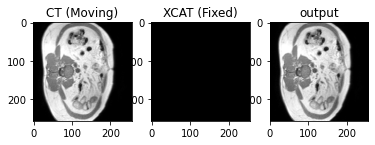

In [34]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(x.cpu().detach().numpy()[0, 0, :, :, 16], cmap='gray')
plt.title('CT (Moving)')
plt.subplot(1, 3, 2)
plt.imshow(y.cpu().detach().numpy()[0, 0, :, :, 5], cmap='gray')
plt.title('XCAT (Fixed)')
plt.subplot(1, 3, 3)
plt.imshow(ct_aff.cpu().detach().numpy()[0, 0, :, :, 16], cmap='gray')
plt.title('output')
plt.show()

In [ ]:
# MSE before and after registration

In [ ]:
import torch.nn as nn
MSE_val = nn.MSELoss()
MSE_before = MSE_val(x, y)
MSE_after = MSE_val(ct_aff, y)
print('MSE berfore: {}, after: {}'.format(MSE_before, MSE_after))

MSE berfore: 3231.59716796875, after: 1071.135498046875


In [ ]:
# Save pre-trained model

In [ ]:
filename='TransMorph_Affine.pth.tar'
torch.save({'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),},
            'experiments/'+save_dir+filename)

# Inference

In [ ]:
# Create model and load weights

In [11]:
config = CONFIGS['TransMorph-Affine']
AffInfer = TransMorph_affine.ApplyAffine()
AffInfer.cuda()
model = TransMorph_affine.SwinAffine(config)
model.cuda()
model.load_state_dict(torch.load('/home/csgrad/mbhosale/Image_registration/registration/experiments/TransMorph_affine_NCC.pth.tar')['state_dict'])

<All keys matched successfully>

In [ ]:
# PyTorch Datasets
infer_dir = 'sample_data/'
infer_composed = transforms.Compose([trans.Pad3DIfNeeded((180, 180, 180)),
                                     trans.CenterCropBySize((160, 160, 160)),
                                     trans.NumpyType((np.float32, np.float32)),
                                     ])
infer_set = datasets.CTDataset(glob.glob(infer_dir + '*.pkl'), transforms=infer_composed)
infer_loader = DataLoader(infer_set, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)


In [ ]:
# Check files

In [ ]:
print(glob.glob(infer_dir + '*.pkl'))

['sample_data\\pt106.pkl', 'sample_data\\pt108.pkl']


In [8]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=6)

In [12]:
def data_extract(samples, n_class):
        if len(samples)==4:
            fixed, fixed_label, moving, moving_label = samples
            fixed_nopad = None
        else:
            fixed, fixed_label, fixed_nopad, moving, moving_label = samples
            
        # Mahesh : Q. Why we need to unsqeeze? >> Make depth/channel as second dimension for conv, i.e. our volume is gray sclae, so it's 1.
        moving = torch.unsqueeze(moving, 1).float().cuda()
        fixed = torch.unsqueeze(fixed, 1).float().cuda()
        # moving_label = torch.unsqueeze(moving_label, 1).float().cuda()
        # fixed_label = torch.unsqueeze(fixed_label, 1).float().cuda()
        fixed_label = fixed_label.float().cuda()
        fixed_label = torch.nn.functional.one_hot(fixed_label.long(), num_classes=n_class).float().permute(0,4,1,2,3)
        moving_label = moving_label.float().cuda()
        moving_label = torch.nn.functional.one_hot(moving_label.long(), num_classes=n_class).float().permute(0,4,1,2,3)
        
        if fixed_nopad is not None:
            # moving_label = fixed_nopad * moving_label
            fixed_nopad = fixed_nopad.float().cuda()[:, None]
            fixed_label = fixed_nopad * fixed_label
        
        # Mahesh : Q. Why do we need to permute here, Is it okay if we do not onehot code? >> To make the class/label dimension second dimension,
        # likely required by the loss.
        # fixed_label = torch.nn.functional.one_hot(fixed_label.long(), num_classes=self.n_class).float().permute(0, 4, 1, 2, 3).cuda()
        # moving_label = torch.nn.functional.one_hot(moving_label.long(), num_classes=self.n_class).float().permute(0, 4, 1, 2, 3).cuda()
        return fixed, fixed_label, moving, moving_label, fixed_nopad

tensor(2405238)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


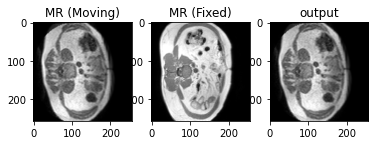

tensor(2301264)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


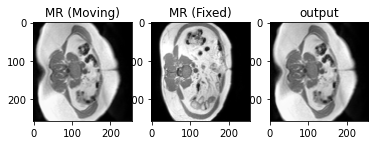

tensor(2522309)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


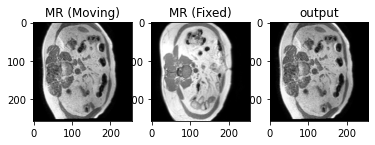

tensor(2405578)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


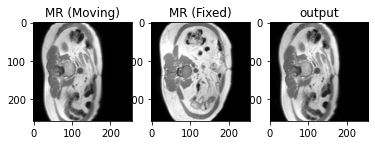

tensor(2355836)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


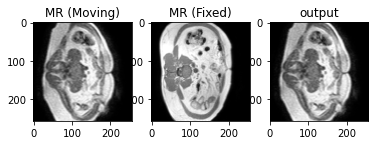

tensor(2281659)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


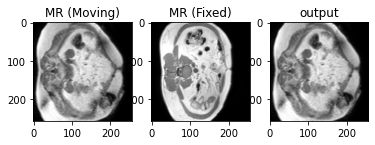

tensor(2272190)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


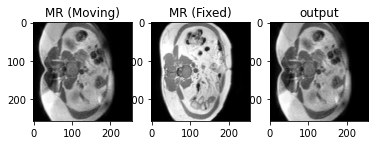

tensor(2401835)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


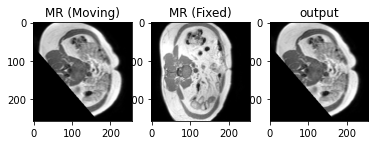

tensor(2286326)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


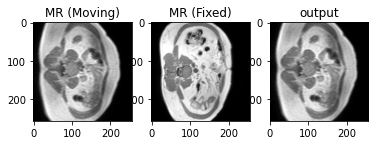

tensor(2306910)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


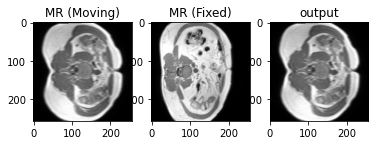

tensor(2629224)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


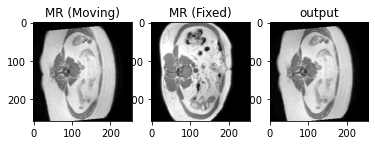

tensor(2289186)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


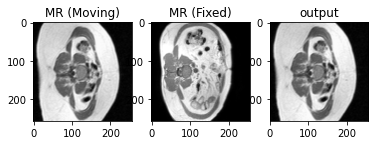

tensor(2311112)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


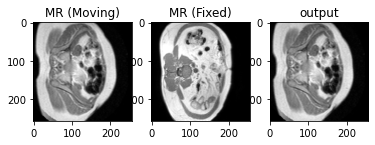

tensor(2415595)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


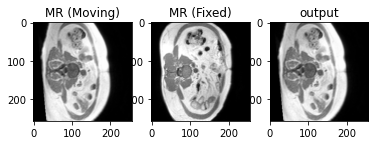

tensor(2510969)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


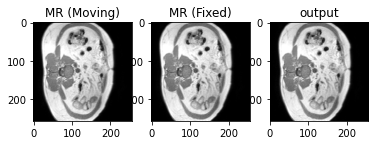

tensor(2311089)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


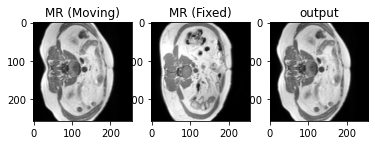

tensor(2539675)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


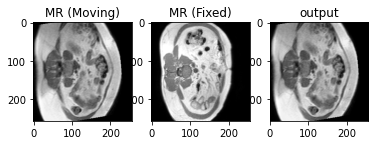

tensor(2366637)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


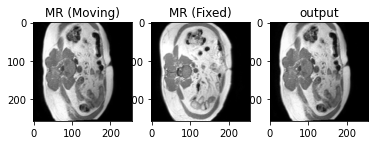

tensor(2410602)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


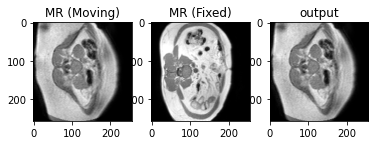

tensor(2319670)
tensor(4194304)
torch.Size([1, 1, 256, 256, 64])


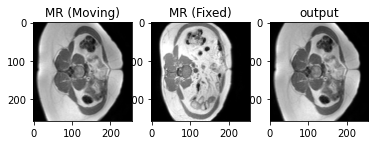

In [26]:
with torch.no_grad():
    for data in test_dataloader:
        p = int(data[-1])
        data = data[:-1]
        data = data_extract(data, 5)
        data = [t.to(device, dtype=torch.float) for t in data]
        x = data[2]
        y = data[0]
        # x = x.unsqueeze(-5)
        # y = y.unsqueeze(-5) 
        model.eval()
        x_in = torch.cat((x, y), dim=1)
        ct_aff, mat, inv_mats = model(x_in)
        phan = y
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(x.cpu().detach().numpy()[0, 0, :, :, 16], cmap='gray')
        plt.title('MR (Moving)')
        plt.subplot(1, 3, 2)
        plt.imshow(y.cpu().detach().numpy()[0, 0, :, :, 16], cmap='gray')
        plt.title('MR (Fixed)')
        plt.subplot(1, 3, 3)
        plt.imshow(ct_aff.cpu().detach().numpy()[0, 0, :, :, 16], cmap='gray')
        plt.title('output')
        print(torch.sum(x.cpu() == ct_aff.cpu()))
        print(x.shape)
        plt.show()